In [253]:
from pymongo import MongoClient
import json
from scipy.spatial.distance import euclidean, pdist, squareform
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [254]:
sns.set(rc={'figure.figsize':(10, 10)})

In [255]:
def similarity_func(u, v):
    return 1/(1+euclidean(u, v))

In [256]:
cfg = json.load(open('config/mongo.json'))

db = 'mongodb://{host}:{port}'.format(**cfg['local'])  # local DB
with MongoClient(db) as client:
    tracksDB = client[cfg['local']['database']]['tracks']
    artistsDB = client[cfg['local']['database']]['artists']

In [257]:
tracks_list = []

for track in tracksDB.find():
    tracks_list.append(track)

tracksDF = pd.DataFrame(tracks_list)
tracksDF['index'] = tracksDF['artist'] + '.' + tracksDF['name']
tracksDF.set_index('index', inplace=True)

In [258]:
attributes = ['acousticness',  'danceability', 'energy',  'instrumentalness', 'key',
              'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode', 'time_signature']

In [259]:
scaler = StandardScaler()

In [267]:
scaled_df = scaler.fit_transform(tracksDF[attributes].dropna())
scaled_df = pd.DataFrame(scaled_df, columns=attributes)
scaled_df.index = tracksDF[attributes].dropna().index
scaled_df.drop_duplicates(inplace=True)

In [268]:
for track in scaled_df.T.corr().columns:
    try:
        neighbours = scaled_df.T.corr()[track].sort_values(ascending = False).head(11)
        for n in neighbours[1:]:
            tracksDB.update_one({'name': track.split('.')[1], 'artist': track.split('.')[0]},
                         {'$push': {'neighbours': {'track': neighbours[neighbours==n].index.format()[0], 
                                                   'score': n}}})
    except Exception as ex:
        print(track)
        print(ex)

Nicolas Jaar.Mi Mujer
sort_values() missing 1 required positional argument: 'by'
Nicolas Jaar.Mi Mujer
sort_values() missing 1 required positional argument: 'by'


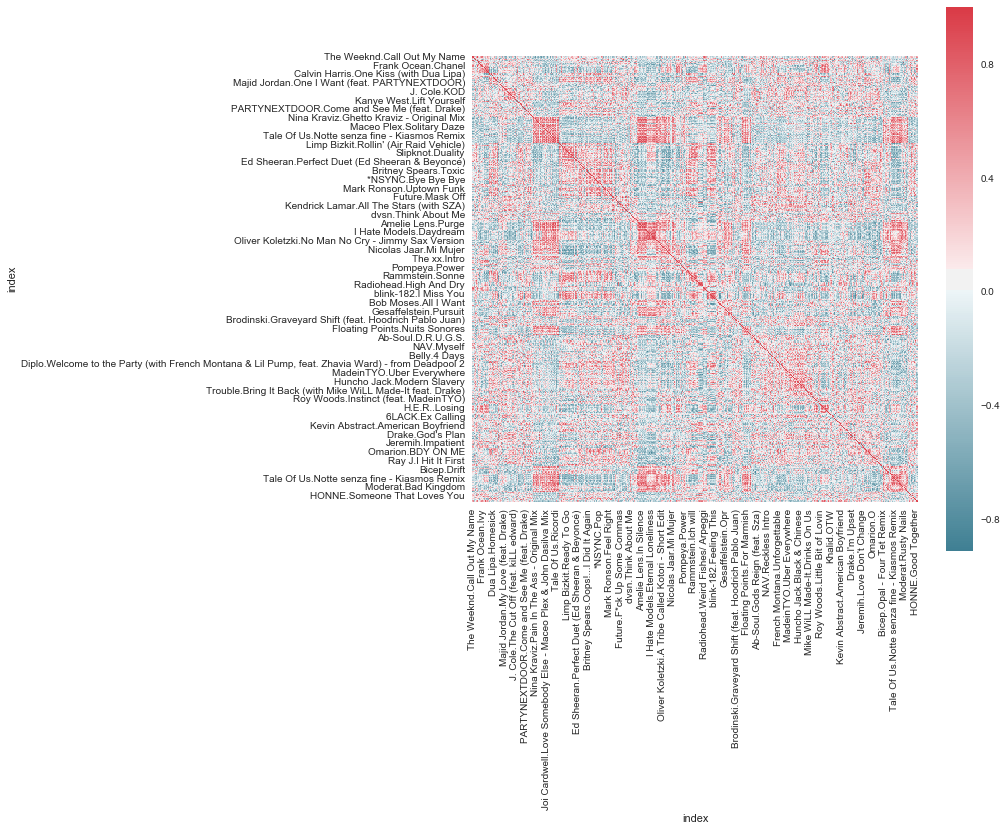

In [187]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(scaled_df.T.corr(), cmap=cmap, square=True)